# Deep Q Leaning

In this notebook, we will implement dqn algorithm to play Cartpole.

## Step 1: Import the libraries

In [1]:
import time
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

## Step 2: Create our environment

In [3]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make('CartPole-v1').unwrapped
env.seed(1)

c:\users\deepanshu\.conda\envs\ai\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[1]

## Step 3: Viewing our Enviroment
Execute the code cell below to play Cartpole with a random policy.

The size of state is:  (4,)
No. of Actions:  2


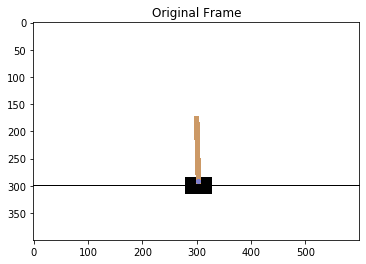

In [4]:
print("The size of state is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
env.reset()
plt.figure()
plt.imshow(env.render(mode='rgb_array'))
env.close()
plt.title('Original Frame')
plt.show()

In [5]:
def random_play():
    env.reset()
    while True:
        env.render(mode='rgb_array')
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        time.sleep(0.05)
        if done:
            env.close()
            break
random_play()

## Step 4: Creating Replay Memory

In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        experiences = random.sample(self.memory, batch_size)
        
        states = torch.FloatTensor(np.array([e.state for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.array([e.action for e in experiences])).long().to(device)
        rewards = torch.from_numpy(np.array([e.reward for e in experiences])).float().to(device)
        next_states = torch.FloatTensor(np.array([e.next_state for e in experiences])).float().to(device)
        
        return (states, actions, rewards, next_states)

    def __len__(self):
        return len(self.memory)

## Step 5: Creating Deep Learning Model

In [9]:
class DQN(nn.Module):
    def __init__(self, state_size = 4, action_size=2):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## Step 6: Creating out agent

In [19]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 0.001              # learning rate 
UPDATE_EVERY = 5        # how often to update the network
class Agent():
    def __init__(self, state_size, action_size):
        self.action_size = action_size
        self.state_size = state_size
        
        # Q-Network
        self.policy_net = DQN(state_size, action_size).to(device)
        self.target_net = DQN(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LR)
        
        # Replay memory
        self.memory = ReplayMemory(BUFFER_SIZE)
        
        self.t_step = 0
    
    def step(self, state, action, reward, next_state):
        # Save experience in replay memory
        self.memory.push(state, action, reward, next_state)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample(BATCH_SIZE)
                self.learn(experiences, GAMMA)
                
    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy."""
        
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        self.policy_net.eval()
        with torch.no_grad():
            action_values = self.policy_net(state)
        self.policy_net.train()
        
        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states = experiences
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.target_net(next_states).detach().max(1)[0].unsqueeze(1)
        
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next)

        # Get expected Q values from local model
        Q_expected = self.policy_net(states).gather(1, actions.unsqueeze(1))
        
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.policy_net, self.target_net, TAU)
        
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

## Step 7: Watching untrained agent play

In [20]:
agent = Agent(state_size=4, action_size= env.action_space.n)

# watch an untrained agent
state = env.reset()
for j in range(200):
    action = agent.act(state)
    env.render()
    next_state, reward, done, _ = env.step(action)
    state = next_state
    time.sleep(0.05)
    if done:
        break 
        
env.close()

## Step 8: Loading Agent

In [21]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=100)

# To Load checkpoint uncomment code
# checkpoint = torch.load('cartpole_2000.pth')
# agent.policy_net.load_state_dict(checkpoint['state_dict'])
# agent.target_net.load_state_dict(checkpoint['state_dict'])
# agent.optimizer.load_state_dict(checkpoint['optimizer'])
# start_epoch = checkpoint['epoch']
# scores = checkpoint['scores']

# index = 1
# for i in reversed(scores):
#     scores_window.append(i)
#     if index == 100:
#         break
#     index += 1

## Step 9: Train the Agent with DQN

In [22]:
def train(n_episodes=2000, eps_start=1.0, eps_end=0.05, eps_decay=0.995):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    eps = eps_start
    for i_episode in range(start_epoch+1, n_episodes+1):
        state = env.reset()
        score = 0
        while True:
            action = agent.act(state.copy(), eps)
            next_state, reward, done, _ = env.step(action)
            score += reward
            if done:
                reward = -100
            agent.step(state, action, reward, next_state)
            state = next_state
            if done:
                env.close()
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 500 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            state = {'epoch': i_episode,'state_dict': agent.policy_net.state_dict(),'optimizer': agent.optimizer.state_dict(),
                     'scores': scores }
            torch.save(state, "cartpole_{}.pth".format(i_episode))
    
    return scores

Episode 3	Average Score: 33.33

c:\users\deepanshu\.conda\envs\ai\lib\site-packages\ipykernel_launcher.py:61: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Episode 500	Average Score: 10.66
Episode 1000	Average Score: 49.08
Episode 1500	Average Score: 249.52
Episode 2000	Average Score: 625.36


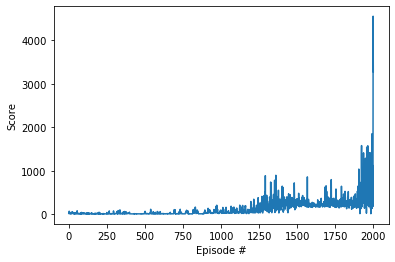

In [23]:
scores = train()
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [29]:
# watch an trained agent
score = 0
state = env.reset()
while True:
    action = agent.act(state)
    env.render()
    next_state, reward, done, _ = env.step(action)
    state = next_state
    score += reward
    time.sleep(0.05)
    if done:
        print("Your total score is: ", score)
        break 
        
env.close()

Your total score is:  225.0
